# Compare tau decay distributions between polarized and unpolarized Tauola

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import load_hepmc, branching_ratios
from collections import Counter
from pprint import pprint
from IPython.display import display

## Compare with and without radiative corrections 

In [2]:
nutau_energies = [5, 10, 20, 50, 100]

decay_products = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
decay_products_nopol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_nopol.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
decay_products_b = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output-b.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
# decay_products_r = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output-r.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
# decay_products_nopol_r = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_nopol-r.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}

0
10000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000
70000
0
10000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000
70000
0
10000
0
10000
20000
30000
40000
0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000
70000


In [4]:
for e in nutau_energies:
    print(f"Energy: {e} GeV")
    # Convert the print statements above to a table. One table for each energy. Each row is a decay mode and each column is the branching ratios for the different simulations.
    table = {}
    table["with polarization"] = {str(key): value for key, value in branching_ratios(decay_products[e]).items()}
    table["without polarization"] = {str(key): value for key, value in branching_ratios(decay_products_nopol[e]).items()}
    table["with polarization, with boosting"] = {str(key): value for key, value in branching_ratios(decay_products_b[e]).items()}
    # table["without polarization, without radiative corrections"] = {str(key): value for key, value in branching_ratios(decay_products_nopol_r[e]).items()}
    df = pd.DataFrame(table)
    # Replace NaN with 0
    df = df.fillna(0)
    display(df)

Energy: 5 GeV


,with polarization,without polarization,"with polarization, with boosting"
"(-211, 16, 111)",0.252223,0.253342,0.252223
"(-14, 13, 16)",0.169677,0.174487,0.169677
"(-12, 11, 16)",0.157262,0.152676,0.157262
"(-211, 16)",0.109614,0.107544,0.109614
"(-211, 16, 111, 111)",0.090431,0.092389,0.090431
"(-211, -211, 16, 211)",0.089592,0.091270,0.089592
"(-211, -211, 16, 111, 211)",0.045635,0.045076,0.045635
"(-12, 11, 16, 22)",0.028019,0.027403,0.028019
"(-211, 16, 111, 111, 111)",0.009563,0.010067,0.009563
"(-321, 16)",0.005984,0.005984,0.005984


Energy: 10 GeV


,with polarization,without polarization,"with polarization, with boosting"
"(-211, 16, 111)",0.252183,0.253759,0.252183
"(-14, 13, 16)",0.171793,0.170287,0.171793
"(-12, 11, 16)",0.149742,0.154755,0.149742
"(-211, 16)",0.108536,0.108841,0.108536
"(-211, 16, 111, 111)",0.092956,0.092721,0.092956
"(-211, -211, 16, 211)",0.091144,0.088415,0.091144
"(-211, -211, 16, 111, 211)",0.046996,0.045678,0.046996
"(-12, 11, 16, 22)",0.028334,0.027934,0.028334
"(-211, 16, 111, 111, 111)",0.010261,0.010637,0.010261
"(-14, 13, 16, 22)",0.006307,0.005224,0.006307


Energy: 20 GeV


,with polarization,without polarization,"with polarization, with boosting"
"(-211, 16, 111)",0.251821,0.252763,0.251821
"(-14, 13, 16)",0.171476,0.170587,0.171476
"(-12, 11, 16)",0.153157,0.154348,0.153157
"(-211, 16)",0.110213,0.109378,0.110213
"(-211, 16, 111, 111)",0.092872,0.091663,0.092872
"(-211, -211, 16, 211)",0.089318,0.088643,0.089318
"(-211, -211, 16, 111, 211)",0.045823,0.046516,0.045823
"(-12, 11, 16, 22)",0.027433,0.027966,0.027433
"(-211, 16, 111, 111, 111)",0.009826,0.010145,0.009826
"(-321, 16)",0.006592,0.006379,0.006592


Energy: 50 GeV


,with polarization,without polarization,"with polarization, with boosting"
"(-211, 16, 111)",0.252776,0.252430,0.252776
"(-14, 13, 16)",0.170924,0.170095,0.170924
"(-12, 11, 16)",0.151817,0.154288,0.151817
"(-211, 16)",0.109926,0.109986,0.109926
"(-211, 16, 111, 111)",0.091753,0.091783,0.091753
"(-211, -211, 16, 211)",0.090080,0.087669,0.090080
"(-211, -211, 16, 111, 211)",0.047496,0.046698,0.047496
"(-12, 11, 16, 22)",0.027289,0.028178,0.027289
"(-211, 16, 111, 111, 111)",0.009734,0.010186,0.009734
"(-321, 16)",0.006600,0.006600,0.006600


Energy: 100 GeV


,with polarization,without polarization,"with polarization, with boosting"
"(-211, 16, 111)",0.253178,0.252279,0.252368
"(-14, 13, 16)",0.169817,0.170060,0.170447
"(-12, 11, 16)",0.153567,0.154010,0.152828
"(-211, 16)",0.110624,0.110924,0.111068
"(-211, 16, 111, 111)",0.092962,0.091635,0.092022
"(-211, -211, 16, 211)",0.087826,0.087626,0.089140
"(-211, -211, 16, 111, 211)",0.045268,0.046453,0.046039
"(-12, 11, 16, 22)",0.027820,0.028120,0.027706
"(-211, 16, 111, 111, 111)",0.010158,0.010072,0.009816
"(-321, 16)",0.006235,0.006634,0.006206


In [16]:
from utils import filter_events
# Filter out events with e or mu, nu_e or nu_mu and a photon
def gamma_events(values, index):
    return (values == 22).any()

event_nums = {}
for e in nutau_energies:
    print(f"Energy: {e} GeV")
    event_nums[e] = {}
    for d, name in zip((decay_products, decay_products_nopol, decay_products_b), ("", "_nopol", "-b")):
        interesting_events = filter_events(d[e], "pdg", gamma_events, engine="numba")
        print(branching_ratios(interesting_events))
        event_nums[e][name] = np.random.choice(interesting_events["event_num"])
        with pyhepmc.open(f"../data/NuTau_{e}.0_GeV_tauola_output{name}.dat") as f:
            for event in f:
                if event.event_number == event_nums[e][name]:
                    display(event)
                    break
    # print(branching_ratios(filter_events(decay_products[e], "pdg", gamma_events, engine="numba")))
    # print(filter_events(decay_products_nopol[e], "pdg", gamma_events, engine="numba"))
    # print(filter_events(decay_products_b[e], "pdg", gamma_events, engine="numba"))


Energy: 5 GeV
{(-12, 11, 16, 22): 0.7965023847376789, (-14, 13, 16, 22): 0.16534181240063592, (-211, 16, 22, 111): 0.03815580286168521}


<GenEvent momentum_unit=1, length_unit=0, event_number=13933, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.8126036484245439, (-14, 13, 16, 22): 0.14427860696517414, (-211, 16, 22, 111): 0.04311774461028192}


<GenEvent momentum_unit=1, length_unit=0, event_number=13336, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7965023847376789, (-14, 13, 16, 22): 0.16534181240063592, (-211, 16, 22, 111): 0.03815580286168521}


<GenEvent momentum_unit=1, length_unit=0, event_number=2143, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

Energy: 10 GeV
{(-12, 11, 16, 22): 0.7931488801054019, (-14, 13, 16, 22): 0.17654808959156784, (-211, 16, 22, 111): 0.030303030303030304}


<GenEvent momentum_unit=1, length_unit=0, event_number=33984, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.809134287661895, (-14, 13, 16, 22): 0.15132924335378323, (-211, 16, 22, 111): 0.03953646898432175}


<GenEvent momentum_unit=1, length_unit=0, event_number=1645, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7931488801054019, (-14, 13, 16, 22): 0.17654808959156784, (-211, 16, 22, 111): 0.030303030303030304}


<GenEvent momentum_unit=1, length_unit=0, event_number=17072, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

Energy: 20 GeV
{(-12, 11, 16, 22): 0.7926078028747433, (-14, 13, 16, 22): 0.17299794661190965, (-211, 16, 22, 111): 0.034394250513347026}


<GenEvent momentum_unit=1, length_unit=0, event_number=37028, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.8018339276617422, (-14, 13, 16, 22): 0.1599592460519613, (-211, 16, 22, 111): 0.038206826286296486}


<GenEvent momentum_unit=1, length_unit=0, event_number=27844, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7926078028747433, (-14, 13, 16, 22): 0.17299794661190965, (-211, 16, 22, 111): 0.034394250513347026}


<GenEvent momentum_unit=1, length_unit=0, event_number=52347, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

Energy: 50 GeV
{(-12, 11, 16, 22): 0.7891067538126362, (-14, 13, 16, 22): 0.17167755991285402, (-211, 16, 22, 111): 0.0392156862745098}


<GenEvent momentum_unit=1, length_unit=0, event_number=4312, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.8011996572407883, (-14, 13, 16, 22): 0.15938303341902313, (-211, 16, 22, 111): 0.03941730934018852}


<GenEvent momentum_unit=1, length_unit=0, event_number=41536, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7891067538126362, (-14, 13, 16, 22): 0.17167755991285402, (-211, 16, 22, 111): 0.0392156862745098}


<GenEvent momentum_unit=1, length_unit=0, event_number=34639, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

Energy: 100 GeV
{(-12, 11, 16, 22): 0.7933279088689992, (-14, 13, 16, 22): 0.17331163547599673, (-211, 16, 22, 111): 0.03336045565500407}


<GenEvent momentum_unit=1, length_unit=0, event_number=25743, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7995943204868154, (-14, 13, 16, 22): 0.15983772819472616, (-211, 16, 22, 111): 0.04056795131845842}


<GenEvent momentum_unit=1, length_unit=0, event_number=9592, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

{(-12, 11, 16, 22): 0.7887896019496344, (-14, 13, 16, 22): 0.17465475223395613, (-211, 16, 22, 111): 0.036555645816409424}


<GenEvent momentum_unit=1, length_unit=0, event_number=3835, particles=8, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [12]:
import pyhepmc

In [ ]:
for e in nutau_energies:
    print(f"Energy: {e} GeV")
    for d, name in zip((decay_products, decay_products_nopol, decay_products_b), ("", "nopol", "-b")):
        interesting_events = filter_events(d[e], "pdg", gamma_events, engine="numba")
        interesting_events = interesting_events[interesting_events["event_num"] == event_nums[e][name]]
        with open(f"../data/interesting_events_NuTau_{e}GeV{name}.dat", "w") as f:
            pyhepmc.write(interesting_events, f)
with pyhepmc.open("")

There are some decay modes with photons in them, which are not included in the PDG decay modes. Are these real or is there something off?

## Compare GENIE + Tauola events

In [2]:
decay_products = load_hepmc("../data/tauola_output_genie_e5.dat").groupby("event_num").nth[3:]
decay_products_nopol = load_hepmc("../data/tauola_output_genie_nopol_e5.dat").groupby("event_num").nth[3:]
# If you want to save the DataFrame to a file, run these line
# decay_products.to_csv("../data/tauola_decays.csv", index=False)
# decay_products_nopol.to_csv("../data/tauola_decays_nopol.csv", index=False)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [3]:
decay_products

,event_num,pdg,E,px,py,pz
3,4,16,1.132845,0.439469,-0.681560,0.790937
4,4,-211,2.542037,-0.439625,0.607542,2.424891
8,5,16,2.374586,0.328642,-0.758280,2.226109
9,5,-211,0.201790,-0.041125,-0.122461,0.067468
10,5,111,1.559740,0.206179,0.640255,1.400763
...,...,...,...,...,...,...
962483,995223,111,3.078066,-1.049161,0.466417,2.852716
962487,995224,16,1.834136,0.497874,-0.366712,1.726731
962488,995224,111,0.296558,0.028991,0.085612,0.248116
962489,995224,111,0.593272,0.097600,0.156441,0.547501


In [89]:
def get_particle_property(decay_products: pd.DataFrame, pdg: int, prop: str) -> tuple[pd.Series, pd.Series]:
    nutau_e = decay_products.query("pdg == 16")[prop]
    anti_nutau_e = decay_products.query("pdg == -16")[prop]
    return nutau_e, anti_nutau_e


def compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins, density=None, **kwargs):
    fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

    for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau, nutau_nopol), (anti_nutau, anti_nutau_nopol))):
        for energies, particle_type in zip(lists, ("polarized", "unpolarized")):
            ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5, density=density)
            # ax.set_title(f"{label} {particle_type}")
            
    for ax in axs.flat:
        ax.set(**kwargs, ylabel="Density of number of neutrinos")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize="large")

    return fig, axs

/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='E [GeV]', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='E [GeV]', ylabel='Density of number of neutrinos'>],
       dtype=object))

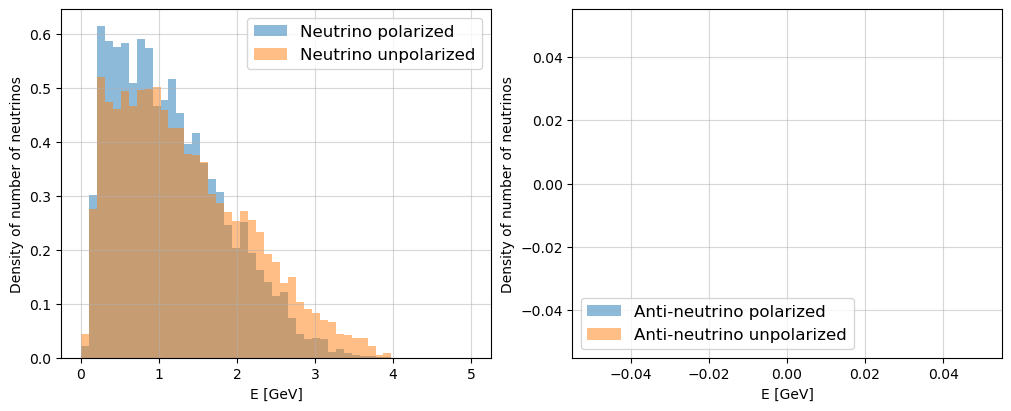

In [90]:
nutau, anti_nutau = get_particle_property(decay_products, 16, "E")
nutau_nopol, anti_nutau_nopol = get_particle_property(decay_products_nopol, 16, "E")

compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins=np.linspace(0, 5, 50), xlabel="E [GeV]", density=True)

When viewing the distribution of all events (regardless of decay mode) and the neutrino energy in these cases, there is a slight shift. In the polarized simulations, the neutrinos typically have a lower energy that in the unpolarized case. This would mean that IceCube simulations using the unpolarized simulations underestimate the energy deposited in the detector, i.e., overestimate the missing energy.

## Pion momentum fraction
See Fig. 2 in the DUNE paper

In [95]:
def is_pion_nutau_event(event: pd.DataFrame) -> bool:
    return (event["pdg"] == -211).any() and (event["pdg"] == 16).any() and (event.shape[0] == 2)

# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = (
    decay_products
    .groupby("event_num")
    .filter(is_pion_nutau_event)
)

pion_neutrino_events_nopol = (
    decay_products_nopol
    .groupby("event_num")
    .filter(is_pion_nutau_event)
)

In [97]:
def pion_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the pion (row 3-4) relative to the tau (row 2)
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return pion_momentum.values / tau_momentum.values


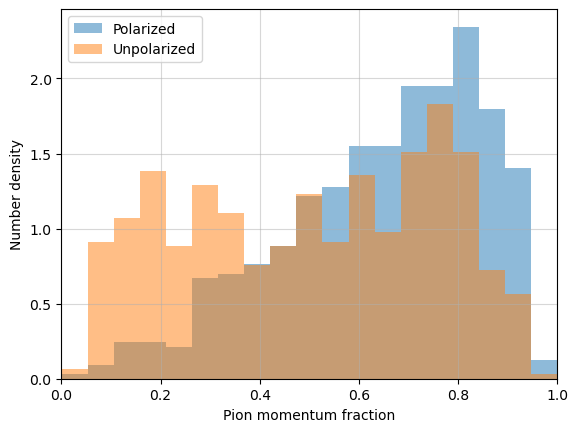

In [98]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(pion_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", alpha=0.5, density=True)
ax.hist(pion_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized", alpha=0.5, density=True)
ax.set(xlim=(0, 1), xlabel="Pion momentum fraction", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

We see a clear difference between the real polarization given by GENIE and the unpolarized decay by Tauola. 
This is good, as the Geant4 decays should have a similar distribution to the Tauola unpolarized decays, which means that the decay distributions should be different between the IceCube simulations and when using Tauola + polarization.